# **Capitulo 2 – Training Models**

# Setup

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

Como hicimos en Notebook anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/training_linear_models` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras en alta resolución para el libro:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Modelos lineales regularizados

Una buena forma de reducir el sobreajuste es regularizar el modelo (es decir, restringirlo): cuantos menos grados de libertad tenga, más difícil será que sobreajuste los datos. Una forma sencilla de regularizar un modelo polinómico es reducir el número de grados polinómicos.

Para un modelo lineal, la regularización se consigue normalmente restringiendo los pesos del modelo. Ahora veremos la regresión de Ridge, la regresión de Lasso y la regresión de ElasticNet, que implementan tres formas diferentes de restringir los pesos.


## Regresión Ridge

La regresión Ridge (también llamada regularización de Tikhonov) es una versión regularizada de la regresión lineal: un término de regularización igual a $ \frac{α}{m} \sum_{i=1}^{n} θ_{i}^2 $ se añade al MSE. Esto obliga al algoritmo de aprendizaje a no solo ajustarse a los datos, sino también a mantener los pesos del modelo lo más pequeños posible. Ten en cuenta que el término de regularización solo debe añadirse a la función de costo durante el entrenamiento. Una vez entrenado el modelo, quieres usar el MSE sin regularizar (o el RMSE) para evaluar el rendimiento del modelo.

El hiperparámetro α controla cuánto quieres regularizar el modelo. Si α = 0, entonces la regresión Ridge es solo regresión lineal. Si α es muy grande, entonces todos los pesos terminan muy cerca de cero y el resultado es una línea plana que pasa por la media de los datos.

Función de costo de la regresión Ridge
$ J(θ) = MSE(θ) + \frac{α}{m} \sum_{i=1}^{n} θ_{i}^2 $

Nota que el término de sesgo $ θ_0 $ no está regularizado (la suma comienza en i = 1, no en 0). Si definimos $ w $ como el vector de pesos de las características (θ₁ a θ_n), entonces el término de regularización es igual a $ \frac{α(‖w‖_2)^2}{m} $, donde $ ‖w‖_2 $ representa la norma ℓ_2 del vector de pesos.

Para el descenso de gradiente por lotes, solo añade $ \frac{2αw}{m} $ a la parte del vector gradiente del MSE que corresponde a los pesos de las características, sin añadir nada al gradiente del término de sesgo.


Es importante escalar los datos (por ejemplo, utilizando un StandardScaler) antes de realizar la regresión ridge, ya que es sensible a la escala de las características de entrada. Esto ocurre con la mayoría de los modelos regularizados.

Generemos un conjunto de datos lineales muy pequeño y ruidoso:

In [48]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

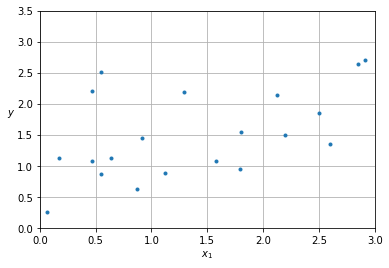

In [49]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [50]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

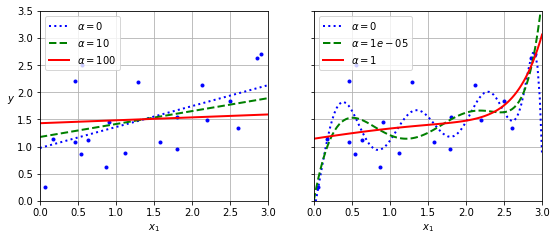

In [51]:

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
# save_fig("ridge_regression_plot")
plt.show()

La figura muestra varios modelos de cresta entrenados con datos lineales muy ruidosos utilizando distintos valores α. A la izquierda, se utilizan modelos de cresta simples, que dan lugar a predicciones lineales. A la derecha, los datos se expanden primero con PolynomialFeatures(degree=10), luego se escalan con StandardScaler y, por último, se aplican los modelos de cresta a las características resultantes: se trata de una regresión polinómica con regularización de cresta. Observe cómo el aumento de α conduce a predicciones más planas (es decir, menos extremas, más razonables), reduciendo así la varianza del modelo, pero aumentando su sesgo.

Al igual que con la regresión lineal, podemos realizar la regresión Ridge ya sea calculando una ecuación de forma cerrada o realizando un descenso de gradiente. Los pros y los contras son los mismos. La Ecuación muestra la solución de forma cerrada, donde A es la matriz identidad de $ (n + 1) × (n + 1) $, excepto con un 0 en la celda superior izquierda, correspondiente al término de sesgo.

Solución de forma cerrada de la regresión Ridge
$ θ = (X^⊺X + αA)^{−1}X^⊺y $

Aquí te mostramos cómo realizar la regresión Ridge con Scikit-Learn utilizando una solución de forma cerrada (una variante de la Ecuación que utiliza una técnica de factorización de matrices de André-Louis Cholesky):


In [52]:
# mostrar que obtenemos aproximadamente la misma solución que antes cuando
# utilizamos el promedio estocástico GD (solver="sag")
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55321535]])

Y utilizando el descenso de gradiente estocástico:

In [53]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() porque fit() espera objetivos 1D
sgd_reg.predict([[1.5]])

array([1.55302613])

El hiperparámetro de penalización establece el tipo de término de regularización a utilizar. Especificar "l2" indica que se desea que SGD añada un término de regularización a la función de coste MSE igual a alfa veces el cuadrado de la norma ℓ2 del vector de pesos. Esto es igual que la regresión ridge, excepto que no hay división por m en este caso; es por eso que pasamos alpha=0.1 / m, para obtener el mismo resultado que Ridge(alpha=0.1)

La clase RidgeCV también realiza regresión de cresta, pero ajusta automáticamente los hiperparámetros mediante Cross-Validation. Es más o menos equivalente a utilizar GridSearchCV, pero está optimizado para la regresión de cresta y se ejecuta mucho más rápido. Otros estimadores (en su mayoría lineales) también tienen variantes CV eficientes, como LassoCV y ElasticNetCV.

In [54]:
# muestra la solución de forma cerrada de la regresión Ridge,
# comparar con los parámetros aprendidos del modelo Ridge
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [55]:
ridge_reg.intercept_, ridge_reg.coef_ 

(array([0.97944909]), array([[0.38251084]]))

## Regresión Lasso

La regresión por mínimo absoluto y operador de selección (normalmente llamada simplemente regresión lasso) es otra versión regularizada de la regresión lineal: al igual que la regresión ridge, añade un término de regularización a la función de coste, pero utiliza la norma $ℓ1$ del vector de pesos en lugar del cuadrado de la norma $ℓ2$. Tenga en cuenta que la norma $ℓ1$ se multiplica por $2α$, mientras que la norma $ℓ2$ se multiplicó por $α / m$ en la regresión de ridge. Estos factores fueron elegidos para asegurar que el valor óptimo de $α$ es independiente del tamaño del conjunto de entrenamiento: diferentes normas conducen a diferentes factores.

Función de coste de regresión Lasso
$$J(\theta) = \text{MSE}(\theta) + 2\alpha \sum_{i=1}^{n} |\theta_i|$$


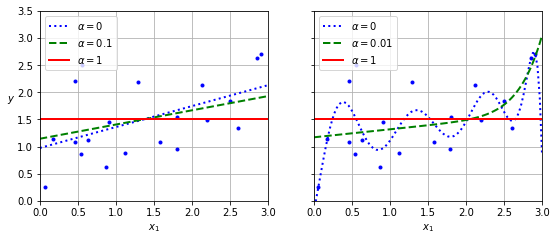

In [57]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
# save_fig("lasso_regression_plot")
plt.show()

La Figura anterior muestra lo mismo que la Figura de hace unas celdas pero sustituye los modelos de ridge por modelos lasso y utiliza diferentes valores α.

Una característica importante de la regresión lasso es que tiende a eliminar los pesos de las características menos importantes (es decir, los pone a cero). Por ejemplo, la línea discontinua del gráfico de la derecha de la figura (con α = 0,01) parece aproximadamente cúbica: todos los pesos de las características polinómicas de alto grado son iguales a cero. En otras palabras, la regresión lasso realiza automáticamente la selección de características y produce un modelo disperso con pocas ponderaciones de características distintas de cero.

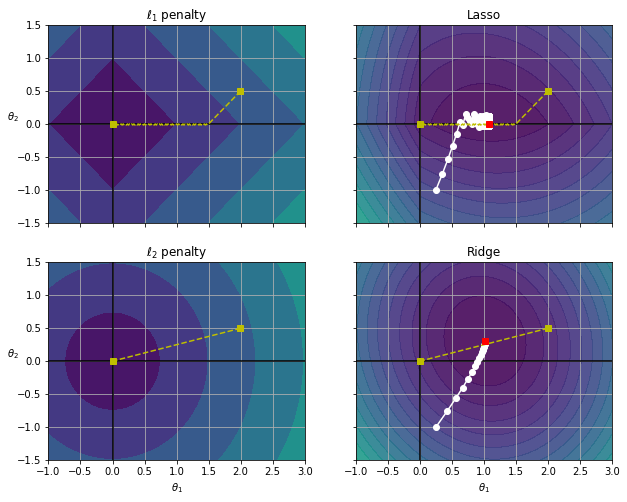

In [59]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

# save_fig("lasso_vs_ridge_plot")
plt.show()

Puede hacerse una idea de por qué ocurre esto observando la figura anterior: los ejes representan dos parámetros de modelo y los contornos de fondo representan diferentes funciones de pérdida. En el gráfico superior izquierdo, los contornos representan la pérdida ℓ1 (|θ1| + |θ2|), que cae linealmente a medida que se acerca a cualquier eje. Por ejemplo, si inicializa los parámetros del modelo a θ1 = 2 y θ2 = 0,5, el descenso por gradiente disminuirá ambos parámetros por igual (como se representa por la línea amarilla discontinua); por lo tanto θ2 llegará a 0 primero (ya que estaba más cerca de 0 para empezar). Después, el descenso por gradiente bajará por el canalón hasta llegar a θ1 = 0 (con un poco de rebote, ya que los gradientes de ℓ1 nunca se acercan a 0: son -1 o 1 para cada parámetro). En el gráfico superior derecho, los contornos representan la función de coste de la regresión lasso (es decir, una función de coste MSE más una pérdida ℓ1). Los pequeños círculos blancos muestran el camino que sigue el descenso gradiente para optimizar algunos parámetros del modelo que se inicializaron en torno a θ1 = 0,25 y θ2 = -1: observe una vez más cómo el camino alcanza rápidamente θ2 = 0, luego rueda por el canalón y acaba rebotando alrededor del óptimo global (representado por el cuadrado rojo). Si aumentáramos α, el óptimo global se desplazaría hacia la izquierda a lo largo de la línea amarilla discontinua, mientras que si disminuyéramos α, el óptimo global se desplazaría hacia la derecha (en este ejemplo, los parámetros óptimos para el MSE no regularizado son θ1 = 2 y θ2 = 0,5).

Los dos gráficos inferiores muestran lo mismo pero con una penalización de ℓ2. En el gráfico inferior izquierdo, se puede ver que la pérdida ℓ2 disminuye a medida que nos acercamos al origen, por lo que el descenso gradiente sólo toma un camino recto hacia ese punto. En el gráfico inferior derecho, los contornos representan la función de coste de la regresión de cresta (es decir, una función de coste MSE más una pérdida ℓ2). Como se puede ver, los gradientes se hacen más pequeños a medida que los parámetros se acercan al óptimo global, por lo que el descenso de gradiente se ralentiza de forma natural. Esto limita el rebote, lo que ayuda a la cresta convergen más rápido que la regresión lasso. Observe también que los parámetros óptimos (representados por el cuadrado rojo) se acercan cada vez más al origen al aumentar α, pero nunca se eliminan por completo.

Para evitar que el descenso gradiente rebote alrededor del óptimo al final cuando se utiliza la regresión lasso, es necesario reducir gradualmente la tasa de aprendizaje durante el entrenamiento. Seguirá rebotando alrededor del óptimo, pero los pasos serán cada vez más pequeños, por lo que convergerá.

La función de costo de Lasso no es diferenciable en $θi = 0 (para i = 1, 2, ⋯, n)$, pero el descenso de gradiente aún funciona si usas un vector subgradiente $g$ en su lugar cuando cualquier $θi = 0$. La Ecuación muestra una ecuación de vector subgradiente que puedes usar para el descenso de gradiente con la función de costo de Lasso.

Equation 4-11. Lasso regression subgradient vector
$$g_{(\theta, J)} = \nabla_{\theta} \text{MSE}(\theta) + 2\alpha \begin{bmatrix}
\text{sign}(\theta_1) \\
\text{sign}(\theta_2) \\
\vdots \\
\text{sign}(\theta_n)
\end{bmatrix}$$ 
donde 
$$\text{sign}(\theta_i) = \left\{
\begin{array}{rl}
-1 & \text{si } \theta_i < 0 \\
0 & \text{si } \theta_i = 0 \\
+1 & \text{si } \theta_i > 0
\end{array} \right.$$


He aquí un pequeño ejemplo de Scikit-Learn utilizando la clase Lasso:

In [60]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Tenga en cuenta que podría utilizar SGDRegressor(penalty="l1", alpha=0.1).

## Elastic Net

La regresión Elastic Net es un punto intermedio entre la regresión Ridge y la regresión Lasso. El término de regularización es una suma ponderada de los términos de regularización tanto de Ridge como de Lasso, y puedes controlar la proporción de la mezcla $ r $. Cuando $ r = 0 $, Elastic Net es equivalente a la regresión Ridge, y cuando $ r = 1 $, es equivalente a la regresión Lasso.

Función de costo de Elastic Net
$$J(\theta) = \text{MSE}(\theta) + r(2\alpha\sum_{i=1}^{n} |\theta_i| )+ (1 - r)(\frac{\alpha}{m}\sum_{i=1}^{n} \theta_i^2)$$

Entonces, ¿cuándo deberías usar la regresión Elastic Net, o Ridge, Lasso o la regresión lineal simple (es decir, sin ninguna regularización)? Casi siempre es preferible tener al menos un poco de regularización, así que generalmente deberías evitar la regresión lineal simple. Ridge es una buena opción por defecto, pero si sospechas que solo unas pocas características son útiles, deberías preferir Lasso o Elastic Net porque tienden a reducir los pesos de las características inútiles a cero, como se discutió anteriormente. En general, se prefiere Elastic Net sobre Lasso porque Lasso puede comportarse de manera errática cuando el número de características es mayor que el número de instancias de entrenamiento o cuando varias características están fuertemente correlacionadas.

Aquí hay un breve ejemplo que usa ElasticNet de Scikit-Learn (l1_ratio corresponde a la proporción de la mezcla $ r $):


In [61]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

Una forma muy distinta de regularizar algoritmos de aprendizaje iterativo como el descenso de gradiente es detener el entrenamiento en cuanto el error de validación alcance un mínimo. Esto se denomina Early Stopping. La Figura a continuación muestra un modelo complejo (en este caso, un modelo de regresión polinómica de alto grado) que se entrena con el descenso de gradiente por lotes en el conjunto de datos cuadráticos que utilizamos anteriormente. A medida que pasan las épocas, el algoritmo aprende, y su error de predicción (RMSE) en el conjunto de entrenamiento disminuye, junto con su error de predicción en el conjunto de validación. Sin embargo, al cabo de un tiempo, el error de validación deja de disminuir y empieza a aumentar. Esto indica que el modelo ha empezado a sobreajustar los datos de entrenamiento. Con la Early Stopping, simplemente se detiene el entrenamiento en cuanto el error de validación alcanza el mínimo. Se trata de una técnica de regularización tan sencilla y eficaz que Geoffrey Hinton la denominó un "hermoso almuerzo gratis"

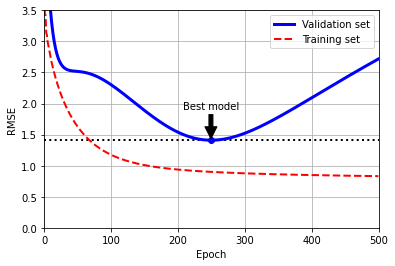

In [63]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# código extra - crea el mismo conjunto de datos cuadráticos que antes y lo divide
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # código extra - es para la figura de abajo

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # código extra - evaluamos el error del tren y lo guardamos para la figura
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
# save_fig("early_stopping_plot")
plt.show()

Este código añade primero las características polinómicas y escala todas las características de entrada, tanto para el conjunto de entrenamiento como para el conjunto de validación (el código asume que has dividido el conjunto de entrenamiento original en un conjunto de entrenamiento más pequeño y un conjunto de validación). A continuación, crea un modelo SGDRegressor sin regularización y con una tasa de aprendizaje pequeña. En el bucle de entrenamiento, llama a partial_fit() en lugar de a fit(), para realizar un aprendizaje incremental. En cada época, mide el RMSE en el conjunto de validación. Si es menor que el RMSE más bajo observado hasta el momento, guarda una copia del modelo en la variable best_model. Esta implementación no detiene realmente el entrenamiento, pero te permite volver al mejor modelo después del entrenamiento. Ten en cuenta que el modelo se copia usando copy.deepcopy(), porque copia tanto los hiperparámetros del modelo como los parámetros aprendidos. En cambio, sklearn.base.clone() sólo copia los hiperparámetros del modelo.